In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from linearmodels import PanelOLS, RandomEffects
from linearmodels.panel import compare
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [55]:
total_data = pd.read_csv('MHI_data_filled.csv')
total_data

,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,Severna i yugoiztochna Bulgaria,2011,10.96,30613.0,NaN
1,1,Severozapaden,2011,10.56,5879.0,0.350
2,2,Severen tsentralen,2011,9.27,6396.0,NaN
3,3,Severoiztochen,2011,10.34,8677.0,0.385
4,4,Yugoiztochen,2011,13.28,9660.0,0.455
...,...,...,...,...,...,...
75,75,Severoiztochen,2020,9.24,12164.0,0.286
76,76,Yugoiztochen,2020,10.29,12498.0,0.338
77,77,Yugozapadna i yuzhna tsentralna Bulgaria,2020,5.75,78645.0,NaN
78,78,Yugozapaden,2020,2.99,17642.0,0.390


In [56]:
data_filled = total_data.fillna(total_data['Depression Rate in %'].median())
data_filled.to_csv('MHI_data_filled.csv')


# Panel Data Anlysis and Synthetic Control

#### Distributions

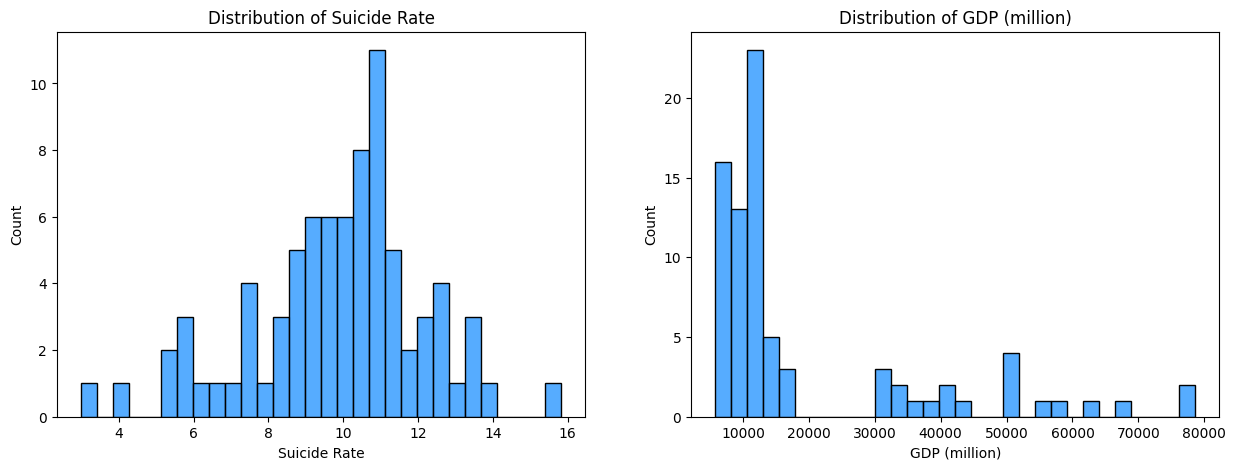

<Figure size 640x480 with 0 Axes>

(       Unnamed: 0         Year  Suicide Rate  GDP (million)  \
 count     80.0000    80.000000     80.000000      80.000000   
 mean      39.5000  2015.500000      9.891000   19822.875000   
 std       23.2379     2.890403      2.317063   18367.045775   
 min        0.0000  2011.000000      2.990000    5769.000000   
 25%       19.7500  2013.000000      8.840000    8955.250000   
 50%       39.5000  2015.500000     10.225000   11721.000000   
 75%       59.2500  2018.000000     11.120000   20884.750000   
 max       79.0000  2020.000000     15.830000   78645.000000   
 
        Depression Rate in %  
 count             80.000000  
 mean               0.368563  
 std                0.049041  
 min                0.260000  
 25%                0.363375  
 50%                0.363500  
 75%                0.363625  
 max                0.525000  ,
 Unnamed: 0              0
 Region                  0
 Year                    0
 Suicide Rate            0
 GDP (million)           0
 Depres

In [59]:

# Basic statistical overview
stats_overview = data_filled.describe()

# Checking for missing values post-filling
missing_values = data_filled.isnull().sum()

# Plotting distributions of numerical variables
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Histogram for Suicide Rate
sns.histplot(data_filled['Suicide Rate'], bins=30, ax=axes[0], color='dodgerblue')
axes[0].set_title('Distribution of Suicide Rate')

# Histogram for GDP (million)
sns.histplot(data_filled['GDP (million)'], bins=30, ax=axes[1], color='dodgerblue')
axes[1].set_title('Distribution of GDP (million)')
plt.show()

# Histogram for Depression Rate in %
sns.histplot(data_filled['Depression Rate in %'], bins=30, ax=axes[1], color='dodgerblue')
axes[1].set_title('Distribution of Depression Rate in %')

plt.tight_layout()
plt.show()

stats_overview, missing_values


In [107]:
data_filled['Region'].unique()

array([1, 3, 0, 2, 4, 6, 5, 7])

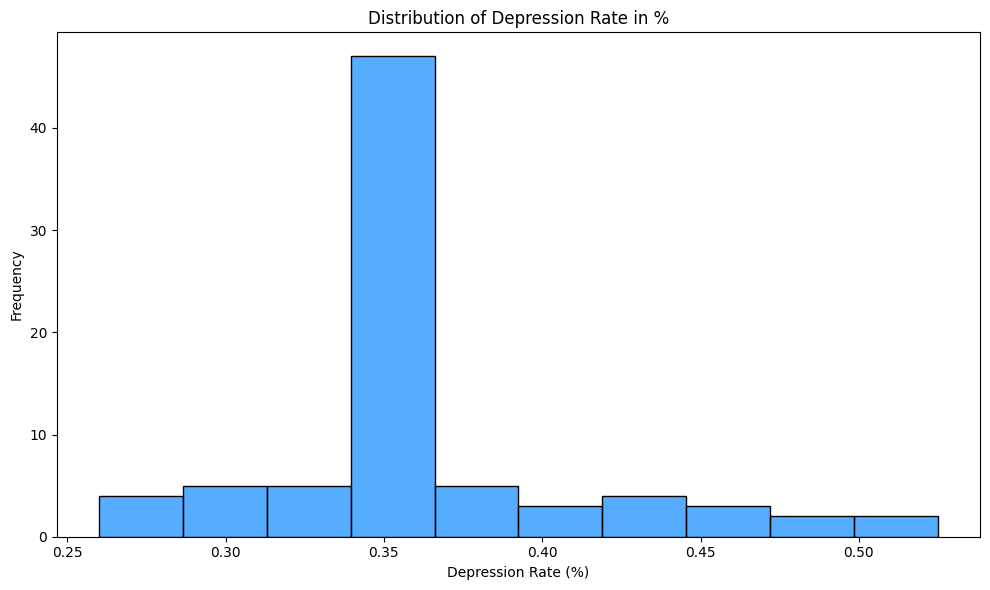

In [66]:
plt.figure(figsize=(10, 6))  # Set the size of the figure

# Creating the histogram for Depression Rate in %
sns.histplot(data_filled['Depression Rate in %'], bins=10, color='dodgerblue')
plt.title('Distribution of Depression Rate in %')
plt.xlabel('Depression Rate (%)')
plt.ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()


In [67]:
# Preparing the data for panel data analysis
panel_data = data_filled.set_index(['Region', 'Year'])

# Defining the dependent and independent variables
independent = panel_data['Suicide Rate']
dependent = panel_data[['GDP (million)']]
independent = sm.add_constant(independent) # adding a constant

# Fixed Effects Model
fe_model = PanelOLS(dependent, independent, entity_effects=True)
fe_results = fe_model.fit()

# Random Effects Model
re_model = RandomEffects(dependent, independent)
re_results = re_model.fit()

# Displaying the results of both models
fe_results.summary, re_results.summary

(<class 'linearmodels.compat.statsmodels.Summary'>
 """
                           PanelOLS Estimation Summary                           
 Dep. Variable:          GDP (million)   R-squared:                        0.1816
 Estimator:                   PanelOLS   R-squared (Between):              0.0649
 No. Observations:                  80   R-squared (Within):               0.1816
 Date:                Fri, Dec 08 2023   R-squared (Overall):              0.0711
 Time:                        16:05:17   Log-likelihood                   -772.56
 Cov. Estimator:            Unadjusted                                           
                                         F-statistic:                      15.758
 Entities:                           8   P-value                           0.0002
 Avg Obs:                      10.0000   Distribution:                    F(1,71)
 Min Obs:                      10.0000                                           
 Max Obs:                      10.0000   F

In [75]:
panel_data = data_filled.set_index(['Region', 'Year'])

# Defining the dependent and independent variables
dependent = panel_data['GDP (million)']
independent = panel_data[['Suicide Rate', 'Depression Rate in %']] # Now includes Depression Rate
independent = sm.add_constant(independent) # adding a constant

# Fixed Effects Model
fe_model = PanelOLS(dependent, independent, entity_effects=True)
fe_results = fe_model.fit()

# Random Effects Model
re_model = RandomEffects(dependent, independent)
re_results = re_model.fit()

# Displaying the results of both models
print(fe_results.summary)
print(re_results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          GDP (million)   R-squared:                        0.1874
Estimator:                   PanelOLS   R-squared (Between):              0.0615
No. Observations:                  80   R-squared (Within):               0.1874
Date:                Fri, Dec 08 2023   R-squared (Overall):              0.0681
Time:                        16:17:19   Log-likelihood                   -772.28
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.0694
Entities:                           8   P-value                           0.0007
Avg Obs:                      10.0000   Distribution:                    F(2,70)
Min Obs:                      10.0000                                           
Max Obs:                      10.0000   F-statistic (robust):             8.0694
                            

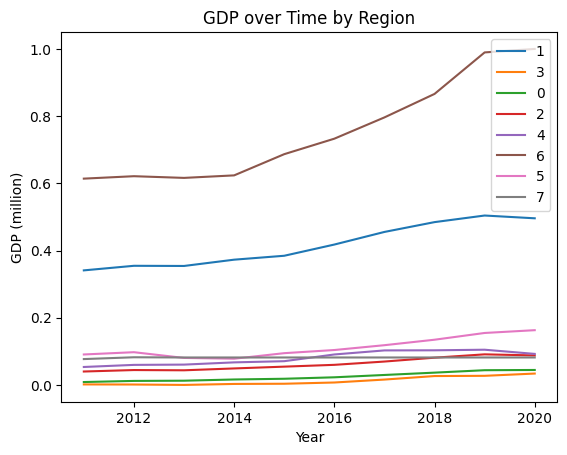

In [240]:
import matplotlib.pyplot as plt

# Grouping the data by region and plotting
for region in data_filled['Region'].unique():
    region_data = data_filled[data_filled['Region'] == region]
    plt.plot(region_data['Year'], region_data['GDP (million)'], label=region)

plt.xlabel('Year')
plt.ylabel('GDP (million)')
plt.title('GDP over Time by Region')
plt.legend()
plt.show()


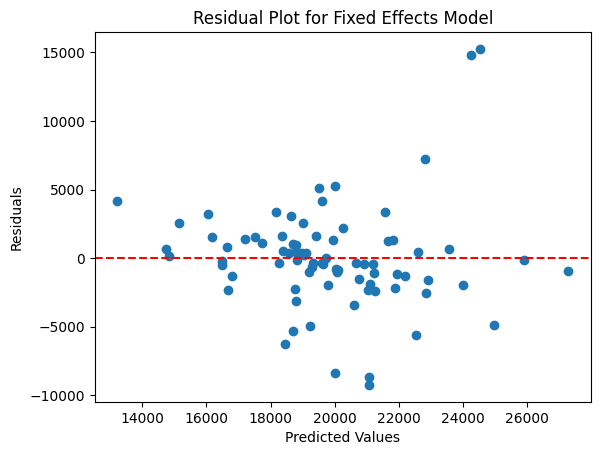

In [241]:
# Extracting residuals from the Fixed Effects model
fe_residuals = fe_results.resids

# Plotting the residuals
plt.scatter(fe_results.predict(), fe_residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Fixed Effects Model')
plt.show()


### Feature Engineering

In [76]:
data_filled.head(10)

,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,Severna i yugoiztochna Bulgaria,2011,10.96,30613.0,0.3635
1,1,Severozapaden,2011,10.56,5879.0,0.3500
2,2,Severen tsentralen,2011,9.27,6396.0,0.3635
3,3,Severoiztochen,2011,10.34,8677.0,0.3850
4,4,Yugoiztochen,2011,13.28,9660.0,0.4550
5,5,Yugozapadna i yuzhna tsentralna Bulgaria,2011,9.78,50512.0,0.3635
6,6,Yugozapaden,2011,8.36,12374.0,0.5250
7,7,Yuzhen tsentralen,2011,11.80,11374.0,0.3635
8,8,Severna i yugoiztochna Bulgaria,2012,12.76,31606.0,0.3635
9,9,Severozapaden,2012,11.51,5857.0,0.3400


In [78]:
# Encoding the Regions from categorical to Numerical variables
if data_filled['Region'].dtype == 'object':
    le = LabelEncoder()
    data_filled['Region'] = le.fit_transform(data_filled['Region'])


In [79]:
data_filled

,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,1,2011,10.96,30613.0,0.3635
1,1,3,2011,10.56,5879.0,0.3500
2,2,0,2011,9.27,6396.0,0.3635
3,3,2,2011,10.34,8677.0,0.3850
4,4,4,2011,13.28,9660.0,0.4550
...,...,...,...,...,...,...
75,75,2,2020,9.24,12164.0,0.2860
76,76,4,2020,10.29,12498.0,0.3380
77,77,6,2020,5.75,78645.0,0.3635
78,78,5,2020,2.99,17642.0,0.3900


Normalizing input features is an important step in preparing your data for use in a machine learning model, including neural networks. Normalization typically involves scaling the data so that the range of the variable is consistent across all features. This process can help improve the performance and training stability of the model. A common method for normalization is Min-Max scaling, which scales the data to a fixed range, usually 0 to 1.

Here's how you can normalize your features - depression rates, suicide rates, and GDP:

1. **Min-Max Normalization**: This scales the data to a range of [0, 1]. The formula is:

   $X_{\text{norm}} = \frac{X - X_{\text{min}}}{X_{\text{max}} - X_{\text{min}}}$

   Where:
   - $X$ is the original value.
   - $X_{\text{min}}$ is the minimum value in the feature.
   - $X_{\text{max}}$ is the maximum value in the feature.
   - $X_{\text{norm}}$ is the normalized value.

2. **Standardization (Z-Score Normalization)**: Another common method is Z-score normalization, where the features are scaled based on their mean (μ) and standard deviation (σ), resulting in a distribution with a mean of 0 and a standard deviation of 1. The formula is:

   $X_{\text{norm}} = \frac{X - \mu}{\sigma}$

   However, for neural networks, Min-Max scaling is often preferred as it keeps the values in a bounded range, which is particularly useful for models using activation functions like sigmoid or tanh.


In [84]:
# Selecting the columns to be normalized
features_to_normalize = ['Suicide Rate', 'GDP (million)']

# Initialize a MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the features
data_filled[features_to_normalize] = scaler.fit_transform(data_filled[features_to_normalize])


In [136]:
data_filled.to_csv('ModelFeeder.csv')
data_filled

,Unnamed: 0,Region,Year,Suicide Rate,GDP (million),Depression Rate in %
0,0,1,2011,0.620717,0.340908,0.3635
1,1,3,2011,0.589564,0.001509,0.3500
2,2,0,2011,0.489097,0.008604,0.3635
3,3,2,2011,0.572430,0.039903,0.3850
4,4,4,2011,0.801402,0.053392,0.4550
...,...,...,...,...,...,...
75,75,2,2020,0.486760,0.087752,0.2860
76,76,4,2020,0.568536,0.092335,0.3380
77,77,6,2020,0.214953,1.000000,0.3635
78,78,5,2020,0.000000,0.162921,0.3900


In [210]:
data_filled.dtypes

Unnamed: 0                int64
Region                    int64
Year                      int64
Suicide Rate            float64
GDP (million)           float64
Depression Rate in %    float64
dtype: object

In [211]:
missing_values = data_filled.isnull().sum()
print(missing_values)


Unnamed: 0              0
Region                  0
Year                    0
Suicide Rate            0
GDP (million)           0
Depression Rate in %    0
dtype: int64


In [212]:
from sklearn.model_selection import train_test_split

# Selecting features and target for OLSCNNModel
features = data_filled[['Depression Rate in %', 'Suicide Rate']]
target = data_filled['GDP (million)']

# Splitting data
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)  # Adjust test_size as needed


In [213]:
sorted_data = data_filled.sort_values(by=['Region', 'Year'])


In [214]:
def create_sequences(data, seq_len):
    sequences = []
    target = []
    for i in range(len(data) - seq_len):
        seq = data[i:i + seq_len]
        label = data.iloc[i + seq_len]['GDP (million)']  # Next year's GDP as the target
        sequences.append(seq[['Depression Rate in %', 'Suicide Rate']].values)
        target.append(label)
    return np.array(sequences), np.array(target)

# Create sequences for each region
seq_len = 5  # Example sequence length
region_sequences = []
region_targets = []
for region in sorted_data['Region'].unique():
    region_data = sorted_data[sorted_data['Region'] == region]
    sequences, targets = create_sequences(region_data, seq_len)
    region_sequences.append(sequences)
    region_targets.append(targets)

# Concatenate all region sequences and targets
final_sequences = np.concatenate(region_sequences)
final_targets = np.concatenate(region_targets)


In [215]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final_sequences, final_targets, test_size=0.2, random_state=42)


In [216]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors
train_features = torch.tensor(X_train, dtype=torch.float32)
train_targets = torch.tensor(y_train, dtype=torch.float32)
test_features = torch.tensor(X_test, dtype=torch.float32)
test_targets = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(train_features, train_targets)
test_dataset = TensorDataset(test_features, test_targets)

# Create DataLoaders
batch_size = 32  # Example batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [217]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# Instantiate the model
input_size = 2  # Number of features (Depression Rate and Suicide Rate)
hidden_size = 50  # Number of features in the hidden state
num_layers = 1  # Number of stacked LSTM layers
output_size = 1  # Output size (GDP)

model = LSTMModel(input_size, hidden_size, num_layers, output_size)


In [218]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100  # Number of epochs
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))  # Make sure targets are correctly shaped
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/100, Loss: 0.14438165724277496
Epoch 2/100, Loss: 0.13812580704689026
Epoch 3/100, Loss: 0.13230708241462708
Epoch 4/100, Loss: 0.12692412734031677
Epoch 5/100, Loss: 0.1219724789261818
Epoch 6/100, Loss: 0.117446169257164
Epoch 7/100, Loss: 0.11333969235420227
Epoch 8/100, Loss: 0.1096496433019638
Epoch 9/100, Loss: 0.10637543350458145
Epoch 10/100, Loss: 0.103519007563591
Epoch 11/100, Loss: 0.10108353942632675
Epoch 12/100, Loss: 0.09907189011573792
Epoch 13/100, Loss: 0.09748408943414688
Epoch 14/100, Loss: 0.09631398320198059
Epoch 15/100, Loss: 0.09554473310709
Epoch 16/100, Loss: 0.09514355659484863
Epoch 17/100, Loss: 0.0950569212436676
Epoch 18/100, Loss: 0.09520934522151947
Epoch 19/100, Loss: 0.09550841152667999
Epoch 20/100, Loss: 0.09585645794868469
Epoch 21/100, Loss: 0.09616560488939285
Epoch 22/100, Loss: 0.0963706374168396
Epoch 23/100, Loss: 0.0964357852935791
Epoch 24/100, Loss: 0.09635408222675323
Epoch 25/100, Loss: 0.09614157676696777
Epoch 26/100, Loss: 0

Epoch 78/100, Loss: 0.08770421892404556
Epoch 79/100, Loss: 0.08749236166477203
Epoch 80/100, Loss: 0.08727280050516129
Epoch 81/100, Loss: 0.0870458111166954
Epoch 82/100, Loss: 0.08681173622608185
Epoch 83/100, Loss: 0.08657081425189972
Epoch 84/100, Loss: 0.0863230973482132
Epoch 85/100, Loss: 0.08606835454702377
Epoch 86/100, Loss: 0.08580615371465683
Epoch 87/100, Loss: 0.0855359137058258
Epoch 88/100, Loss: 0.0852571651339531
Epoch 89/100, Loss: 0.08496958762407303
Epoch 90/100, Loss: 0.08467330038547516
Epoch 91/100, Loss: 0.08436878770589828
Epoch 92/100, Loss: 0.0840567871928215
Epoch 93/100, Loss: 0.08373814076185226
Epoch 94/100, Loss: 0.08341354876756668
Epoch 95/100, Loss: 0.08308351039886475
Epoch 96/100, Loss: 0.08274827897548676
Epoch 97/100, Loss: 0.08240829408168793
Epoch 98/100, Loss: 0.0820644274353981
Epoch 99/100, Loss: 0.08171834796667099
Epoch 100/100, Loss: 0.08137241750955582


In [219]:
model.eval()  # Set the model to evaluation mode
test_losses = []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets.unsqueeze(1))
        test_losses.append(loss.item())
average_loss = sum(test_losses) / len(test_losses)
print(f'Test Loss: {average_loss}')


Test Loss: 0.05268000811338425


In [221]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd


In [236]:
class CustomOLSLayer(nn.Module):
    def __init__(self, input_features, output_features):
        super(CustomOLSLayer, self).__init__()
        # Define a linear layer
        self.linear = nn.Linear(input_features, output_features)

    def forward(self, x):
        # Apply the linear layer
        return self.linear(x)

class OLSCNNModel(nn.Module):
    def __init__(self, n_features, cnn_output_size):
        super(OLSCNNModel, self).__init__()
        
        # OLS-like layer
        self.ols_layer = CustomOLSLayer(input_features=n_features, output_features=1)
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self._to_linear = None
        self._calculate_to_linear(n_features)

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 50)
        self.fc2 = nn.Linear(50, 1)

    def _calculate_to_linear(self, n_features):
        # Dummy data to calculate the flattened size
        x = torch.randn(32, 1, n_features)
        x = self.conv1(x)
        # Flatten and calculate the total number of features
        self._to_linear = torch.flatten(x, start_dim=1).shape[1]

    def forward(self, x):
        # Forward pass through OLS-like layer
        x = self.ols_layer(x)

        # Reshape for Conv1d layer
        x = x.view(x.size(0), 1, -1)

        # Forward pass through CNN layers
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [237]:
model = OLSCNNModel(n_features=2, cnn_output_size=10)


In [238]:
criterion = nn.MSELoss()  # Mean Squared Error is common for regression tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam is a widely used optimizer


In [239]:
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Clear existing gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets.unsqueeze(1))  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update model parameters


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x32 and 64x50)